<h3>Computer Vision Libraries</h3>

torchvision - datasets, model architectures, image transformations\
torchvision.datasets - datasets for image classification, object detection, etc., and base classes for custom datasets\
torchvision.models - computer vision model architectures\
torchvision.transforms - transformations for processing, augmenting, etc.\
torch.utils.data.Dataset - base dataset class\
torch.utils.data.DataLoader - creates iterable over a dataset

In [43]:
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

<h3>FashionMNIST Data</h3>

In [44]:
train_data = datasets.FashionMNIST(
    root='data',
    train=True,
    download=True,
    transform=ToTensor(), # PIL formatted images to tensors
    target_transform=None # for transforming labels
)

test_data = datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor(),
)

In [45]:
image, label = train_data[0]
image, label

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
           0.2863, 0.0000, 0.0000, 0.0039, 

In [46]:
# [color_channel, height, width]
image.shape

torch.Size([1, 28, 28])

In [47]:
len(train_data.data), len(train_data.targets), len(test_data.data), len(test_data.targets)

(60000, 60000, 10000, 10000)

In [48]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

Text(0.5, 1.0, '9')

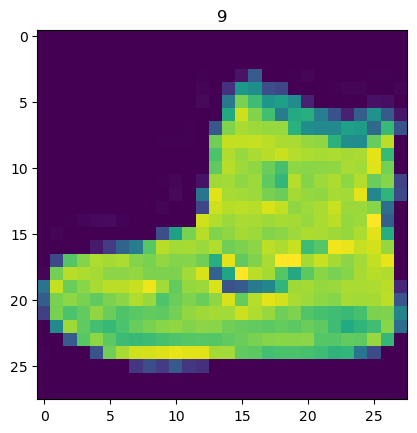

In [49]:
plt.imshow(image.squeeze())
plt.title(label)

Text(0.5, 1.0, 'Ankle boot')

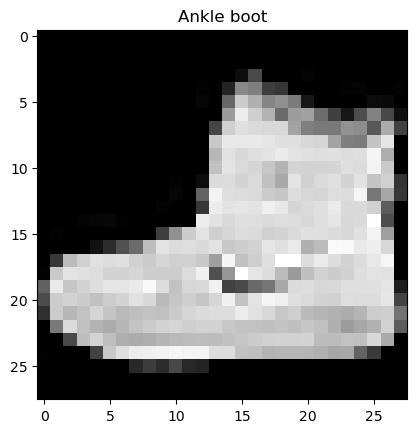

In [50]:
plt.imshow(image.squeeze(), cmap='gray')
plt.title(class_names[label])

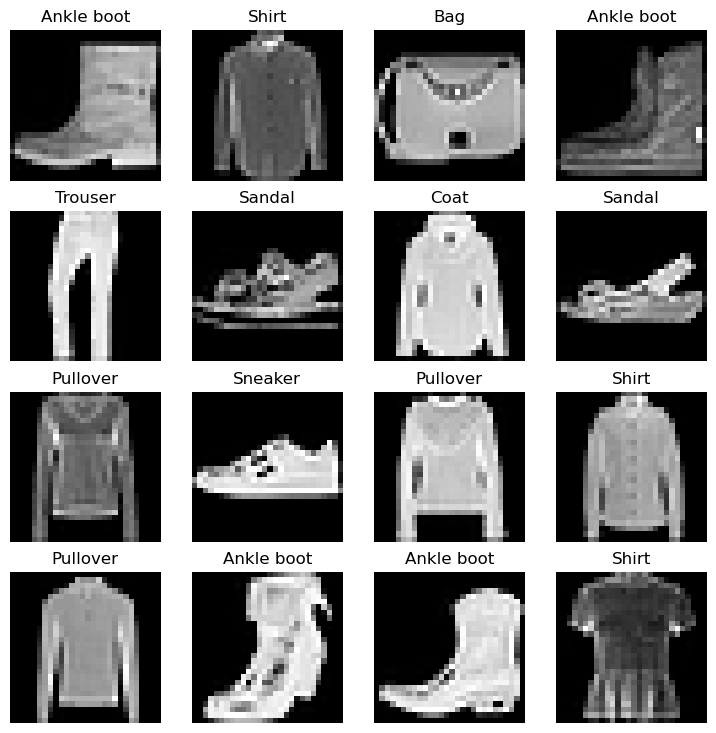

In [51]:
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(class_names[label])
    plt.axis(False)

<h3>DataLoader</h3>

* DataLoader turns a Dataset into an iterable of smaller chunks (batches/mini-batches) set by batch_size parameter
* Batches better for limited compute power
* Gradient descent performed per batch rather than per epoch
* 32 is a decent batch size, with other common sizes being powers of 2

In [52]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(train_data, # dataset to turn into an iterable
                              batch_size=BATCH_SIZE, # samples per batch
                              shuffle=True) # shuffle data every epoch

test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

print(f'Dataloaders: {train_dataloader, test_dataloader}')
print(f'Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}')
print(f'Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}')

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x000002348F296AB0>, <torch.utils.data.dataloader.DataLoader object at 0x00000234A1B9E0C0>)
Length of train dataloader: 1875 batches of 32
Length of test dataloader: 313 batches of 32


In [53]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

<h3>Build Baseline Model</h3>

In [54]:
# nn.Flatten() useful to turn data into feature vectors
flatten_model = nn.Flatten()
x = train_features_batch[0]
output = flatten_model(x)
print(f"Shape before flattening: {x.shape} -> [color_channels, height, width]")
print(f"Shape after flattening: {output.shape} -> [color_channels, height*width]")

Shape before flattening: torch.Size([1, 28, 28]) -> [color_channels, height, width]
Shape after flattening: torch.Size([1, 784]) -> [color_channels, height*width]


In [55]:
class FashionMNISTModelV0(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )

    def forward(self, x):
        return self.layer_stack(x)

In [56]:
torch.manual_seed(42)

model_0 = FashionMNISTModelV0(input_shape=784, # 1 for every pixel (28 x 28)
                              hidden_units=10, 
                              output_shape=len(class_names)) # 1 for every class
model_0.to('cpu')

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [57]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_0.parameters(), lr=0.1)

In [58]:
from timeit import default_timer as timer

def print_train_time(start: float, end: float, device: torch.device=None):
    total_time = end - start
    print(f'Train time on {device}: {total_time:.3f} seconds')

    return total_time

In [59]:
from tqdm.auto import tqdm
import torchmetrics

torch.manual_seed(42)
train_time_start_on_cpu = timer()

epochs = 3
accuracy = torchmetrics.Accuracy(task='multiclass', num_classes=len(class_names)).to('cpu')

for epoch in tqdm(range(epochs)):
    print(f'Epoch: {epoch}\n-------')
    # Train
    train_loss = 0
    for batch, (X, y) in enumerate(train_dataloader):
        model_0.train()
        y_pred = model_0(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch % 400 == 0:
            print(f'Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples')
    train_loss /= len(train_dataloader)

    # Test
    test_loss, test_acc = 0, 0
    model_0.eval()
    with torch.inference_mode():
        for X, y in test_dataloader:
            test_pred = model_0(X)
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy(test_pred, y)
        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)
        # torchmetrics.Accuracy returns decimal
        test_acc *= 100
    print(f'\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n')

train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_on_cpu,
                                            end=train_time_end_on_cpu,
                                            device=str(next(model_0.parameters()).device))

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.59039 | Test loss: 0.50954, Test acc: 82.04%

Epoch: 1
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.47633 | Test loss: 0.47989, Test acc: 83.20%

Epoch: 2
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.45503 | Test loss: 0.47664, Test acc: 83.43%

Train time on cpu: 99.760 seconds
